## Imports


In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from matplotlib.path import Path 
from io import BytesIO

%matplotlib inline 

##### Load data from the json source file in variables
This loads the file 'trip_final.json' that is available from the Montréal Open Data Portal at: 
http://donnees.ville.montreal.qc.ca/dataset/mtl-trajet
The website also contains an explaination of the methodology and the contents of this and related data-sets.
A direct link to the json zip file is at the url below:
http://depot.ville.montreal.qc.ca/mtl-trajet-2016/trip_final_2016_json.zip

For this notebook, you will also need to have the borough shapefiles, which can be dowloaded from:
http://donnees.ville.montreal.qc.ca/dataset/polygones-arrondissements

The .py file run in the cell below loads the data from the LIMADMIN.json file

##### Note:
    - You will need to change the json_filepath variable to the location of trip_final.json and LIMADMIN.json

In [12]:
%run "load_trip_data.py"

## Variable reference: what you need to know

Because the loading of the files is happening in the 'load_trip_data.py' python file, it's worth explaining some of the variables here that will be used throughout the notebook.

    - trip_final: a library that is created by loading the json file into Python. 
    - coords_if: a 293,330-row by 4-column numpy array (293330, 4) that contains the initial [0][1] and final [2][3] coordinates for each entry, made from 'trip_final' 
    - burrShapes: contains the coordinates from the shapefiles for the different boroughs of Montréal. Coordinates are in Latitude - Longitude (Thankfully)
    - numIds: integer that reflects the number of trajectories in the original data set, used to iterate through trip_final
    - ids: A vector of length numIds that contains the unique ID number associated with each recorded trajectory. This is used for comparing subsets and applying selection criteria.

## Process the data
This section contains the operations to arrange the data appropriately to be visualized in the next section. This is the most time-consuming and memory-intensive part to run.

Create a Path object that hold the shapes of the individual burroughs

In [15]:
allPaths=Path(np.empty((1,2)))
currBurr=0
for currBurr in range(0,34):
    currBurr_array=[]
    currBurr_array=np.asarray(burrShapes['features'][currBurr]['geometry']['coordinates'][0][0])
    currBurrPath = Path(currBurr_array)
    allPaths = Path.make_compound_path(allPaths,currBurrPath)

Create 'masks' - boolean lists of rows that match our criteria, that will be applied to the ID list to filter.

In [16]:
# Find all the ids for trajectories that begin outside of the collection of all boroughs (on the island)
mask1 = allPaths.contains_points(coords_if[:,:2])

# Invert the selection to instead have the rows for all trajectories starting outside the collection of boroughs
mask1_inv=np.invert(mask1.astype(bool))

# Use the 'mask' to create a list of the IDs that start off the island
startIds=ids[mask1_inv.astype(bool)]

# Use the same method above to generate a list of IDs for trajectories ending on the island.
mask2 = allPaths.contains_points(coords_if[:,2:])
endIds=ids[mask2]

# Find the overlap of those two sets of IDs to find keep only the trajectories starting off and ending on the island.
mask3=np.isin(startIds, endIds, assume_unique=True)
sharedIDs=startIds[mask3]

# Initialize empty arrays to hold the initial and final points
startPts=np.empty((numIds,2))
endPts=np.empty((numIds,2))

# Iterate through the dictionary and store the start and endpoints to seperate numpy arrays.
iS=0
for nTraj in range(0,numIds):
    tempID=trip_final["features"][nTraj]["properties"]["id_trip"]
    if sum(np.isin(sharedIDs,tempID))>0:
        if trip_final["features"][nTraj]["geometry"] is not None: 
            tempArray=[]
            tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
            startPts[iS,0:2] = tempArray[0,0:2]
            endPts[iS,0:2] = tempArray[-1,0:2]
            iS=iS+1   
     

Load trajectories into a single numpy array for visualizing iteratively

In [18]:
# Create a mask 
currMask=np.isin(ids, sharedIDs, assume_unique=False)  # Using ids instead of allIDs 
currIDs=ids[currMask]

In [35]:
# Set the length cutoff based on the histogram above.
length_cutoff = 600 # Limits the maximum pairs of coordinates for each trajectory. 
nIds = np.size(currIDs)
coordMat = np.empty((nIds,length_cutoff,2)) # 3rd dimension to represent the 2 geospatial coordinates

In [21]:
i_id=0
trim_count=0
drop_count=0 # Dropped for having length of 1.
for nTraj in range(0,numIds):    # For each element of the big list
    tempID=trip_final["features"][nTraj]["properties"]["id_trip"] # This id from the list
    if sum(np.isin(currIDs,tempID))>0:    # If this ID is on our list
        if trip_final["features"][nTraj]["geometry"] is not None:    # And it is not an empty entry
            tempArray=[]
            tempArray=np.asarray(trip_final["features"][nTraj]["geometry"]["coordinates"][0][:]) # Load data as array instead of as a list.
            if tempArray.size > 2: # Use this to filter out single points
                curr_len = tempArray.size/2
                if(curr_len < length_cutoff):
                    temp_i = int(length_cutoff-curr_len) # To make sure they all end at the same time.
                    # May need further mods to tempArray to make it fit into the matrix as intended.
                    coordMat[int(i_id), temp_i:, :] = tempArray      # Add that slice vector to the coordMat array (to the end for visualization purposes)
                    i_id=i_id+1    
                else:
                      trim_count=trim_count+1
            else: 
                drop_count=drop_count+1

In [37]:
print(trim_count, drop_count, trim_count/nIds) 

132 0 0.010599004335956319


As we can see above, none of the trajectories are dropped for only having a single value, and only 132 are excluded for being too long (just over 1% of the starting data)

## Visualize and export

##### Test to see that the operations properly limited our selection to the intended trajectories

In [23]:
# Set the values for all the plots here. I determined these to be the area of interest for this dataset.
xmin = -74
xmax = -73.4
ymin = 45.3
ymax = 45.8

Text(0.5,1,'Final point of trajectory')

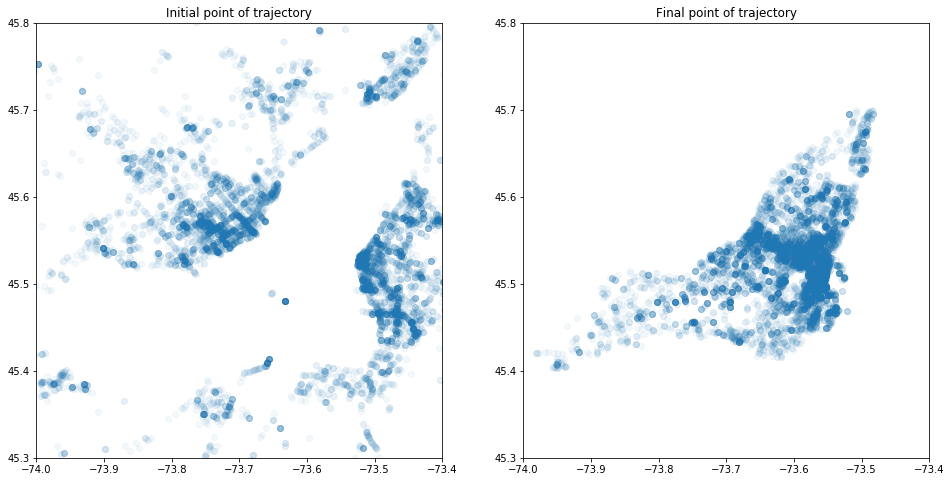

In [38]:
fig1, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
ax1.scatter(startPts[:,0],startPts[:,1], alpha=0.05)
ax1.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

# fig1, (ax) = plt.subplots(1, figsize=(8, 8))
ax2.scatter(endPts[:,0],endPts[:,1], alpha=0.05)
ax2.axis([xmin, xmax, ymin, ymax]) 

ax1.set_title("Initial point of trajectory")
ax2.set_title("Final point of trajectory")

##### Start by plotting a static image inline to be sure the plot looks as intended:

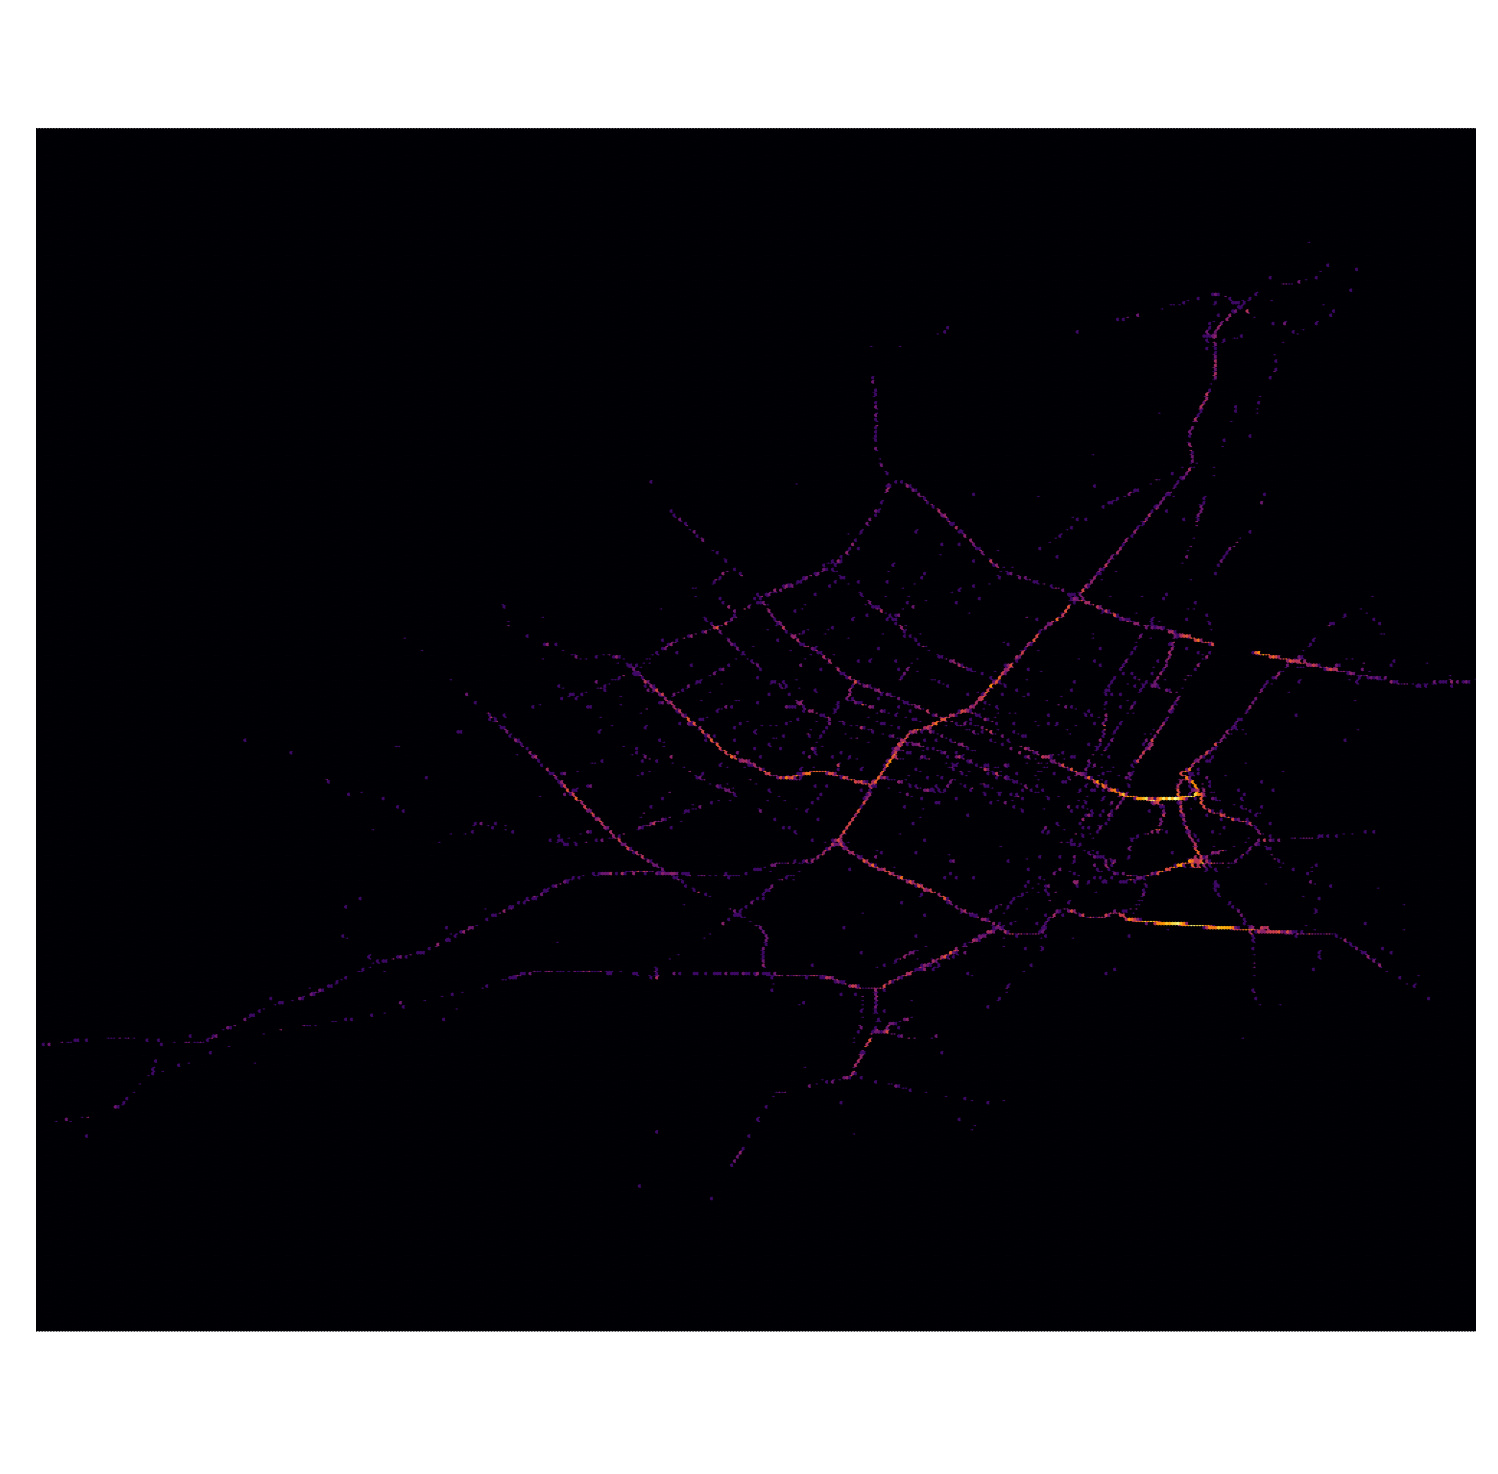

In [31]:
directory= '/output/' # Set the directory where you would like to export the file.

if not os.path.exists(directory):
    os.makedirs(directory)

fig = plt.figure(frameon=False) 
fig.set_size_inches(20,20)

# To make the content fill the whole figure
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()

t=length_cutoff-100 # Set a single t value to slice the multidimensional array.
x1=np.copy(np.squeeze(coordMat[:,t,0])) # With the above note in mind, this may be an exception??
y1=np.copy(np.squeeze(coordMat[:,t,1]))

# Remove the nans from the array
x1 = x1[~np.isnan(x1)]
y1 = y1[~np.isnan(y1)]

# Log colormap
hb = ax.hexbin(x1, y1, gridsize=500, bins='log', cmap='inferno',extent=(xmin, xmax, ymin, ymax))

fig.add_axes(ax)
ax.axis('equal')
plt.axis('off')
ax.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.

# save figure as png
png1 = BytesIO()
filename= directory+'testImage_'+ str(t) +'.png'
fig.savefig(filename, format='png', bbox_inches='tight', pad_inches=0)


##### Process the coordinate matrix 'coordMat' to create a timeseries.
Although it would be more elegant to export a gif directly, I haven't had this working to my satisfaction, so the code below exports a sequence of .png files that can be combined in another step or another program (I use Fiji). 
Note that this is the same code as in the cell above, contained within a for loop that iterates through each element (t) of the dimension corresponding to time.

C:\Users\tyler\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


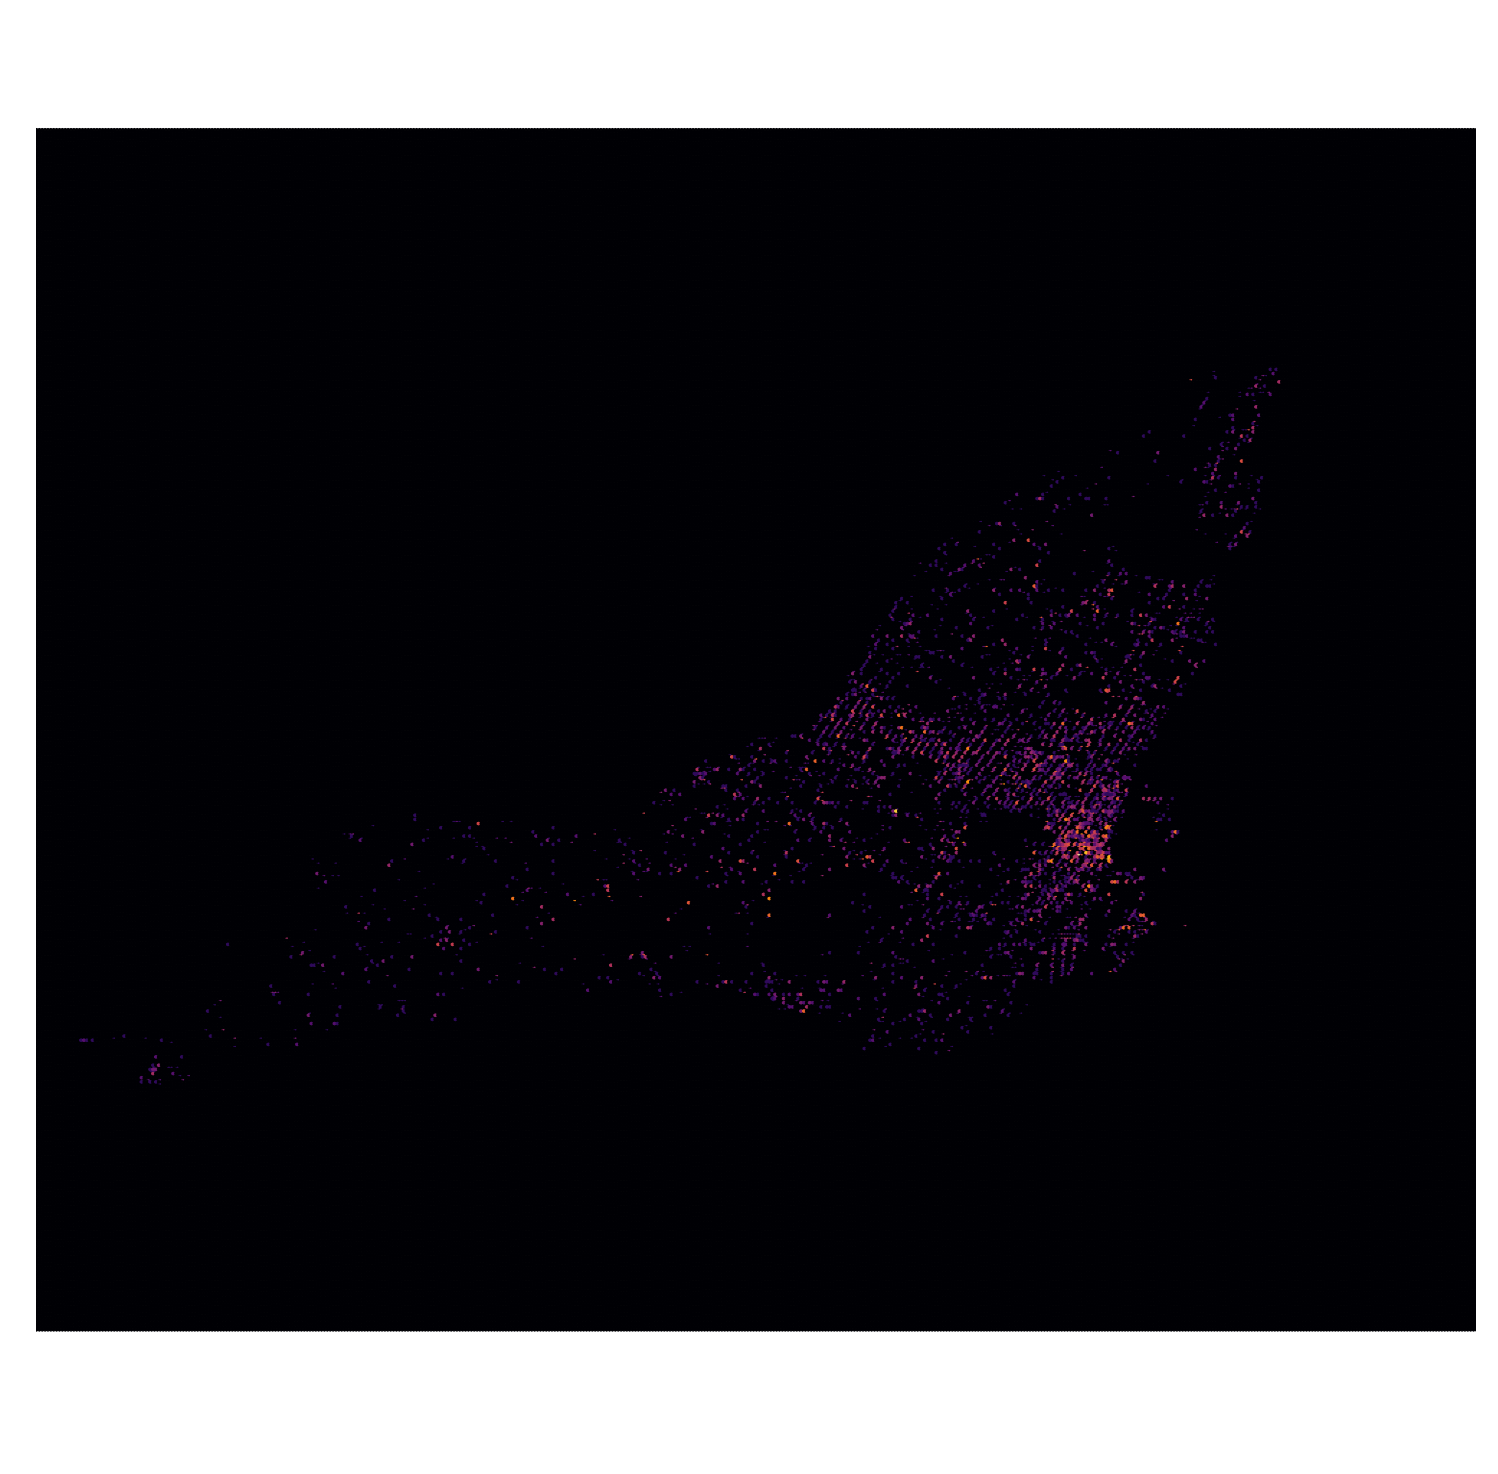

In [32]:
directory= '/output/'

fig = plt.figure(frameon=False) 
fig.set_size_inches(20,20)

# To make the content fill the whole figure
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()

for t in range(0,length_cutoff):
    ax.clear()
    x1=np.copy(np.squeeze(coordMat[:,t,0])) # With the above note in mind, this may be an exception??
    y1=np.copy(np.squeeze(coordMat[:,t,1]))

    # Remove the nans from the array
    x1 = x1[~np.isnan(x1)]
    y1 = y1[~np.isnan(y1)]

    # Log colormap
    hb = ax.hexbin(x1, y1, gridsize=500, bins='log', cmap='inferno',
                   extent=(xmin, xmax, ymin, ymax))
    
    fig.add_axes(ax)
    ax.axis('equal')
    plt.axis('off')
    ax.axis([xmin, xmax, ymin, ymax]) 
    
    # save figure as png
    png1 = BytesIO()
    filename= directory+'hexbin_trip_final_'+ str(t) +'.png'
    fig.savefig(filename, format='png', bbox_inches='tight', pad_inches=0)
 
    


If the cell completes as it should, a heatmap of the points contained within the island of Montreal should be plotted inline above. 
And there you go, now the individual png files can be combined to make an animation.

A few things to experiment with:
    - Changing the colormap used: change cmap='inferno' to a different colormap that can be seen described in the matplotlib gallery here:
            https://matplotlib.org/users/colormaps.html
    - Changing the number of bins (gridsize=Xxx). While I settled on 500 to be able to make out the seperate streets while still pooling data together in individual tiles, I have also experimented with 100 (more pixelated, but cool looking) and 1000 (finer details, almost beving like a scatter plot)
    - If you want a direct numerical output of the counts, remove the log (bins='log') argument from hexbin - then you'll only be able to see the densest areas, such as highways.
    - Different plot types:
            - If you want to see each data point individually, using a scatter plot instead of hexplot would be the way to go ( suggest setting alpha < 0.5 to add transparency to the points)
            - Contour plots are a nice way of visualizing the group behaviour, while losing some information about individual points.
            - You can really test any kind of 2d representation, now that the vectors x1 and y1 are being created for each value of t. A few good references for plot types can be found here:
                    - Python graph gallery: https://python-graph-gallery.com/
                    - Seaborn plot gallery: http://seaborn.pydata.org/examples/index.html
                    - Bokeh plot gallery: https://bokeh.pydata.org/en/latest/docs/gallery.html